In [1]:
using Polynomials
using Controlz
using Test
using DifferentialEquations
using Logging
using DataFrames
using PyPlot
PyPlot.matplotlib.style.use("https://raw.githubusercontent.com/SimonEnsemble/Controlz.jl/master/src/hipster.mplstyle")

In [2]:
τ = 3.45
g = 1 / (τ * s + 1) # FO system
data = simulate(g / s, 10.0) # unit step response
y_at_τ = interpolate(data, τ) # 0.63

0.6320802858882434

## First order plus time delay, response to step

$g(s)=\dfrac{Ke^{-\theta s}}{\tau s + 1}$

response to step input $U(s)=1/s$.

In [3]:
K = 2.0 # gain
τ = 4.0 # time constant
θ = 1.5 # time delay
g = K * exp(-θ * s) / (τ * s + 1) # FOPTD transfer function


    2.0
----------- e^(-1.5*s)
4.0*s + 1.0

In [18]:
U = 1 / s # step input
Y = g * U

data = simulate(Y, 15.0);

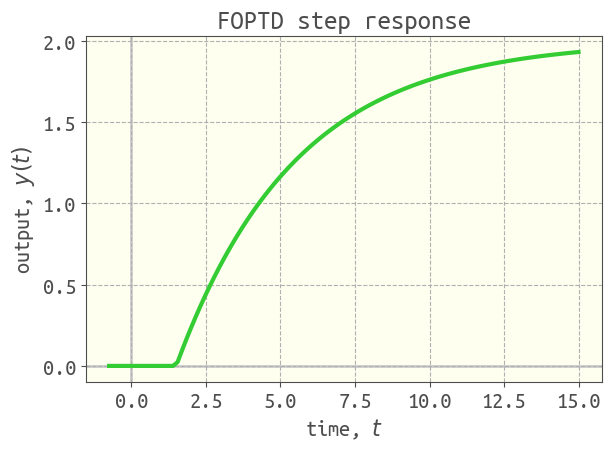

In [6]:
viz_response(data, plot_title="FOPTD step response")
tight_layout()
savefig("../docs/src/FOPTD_step_response.png", format="png")

## Second order underdamped, response to step

$g(s)=\dfrac{4}{4 s ^2 + 0.8 s + 1}$

response to step input $U(s)=1/s$.

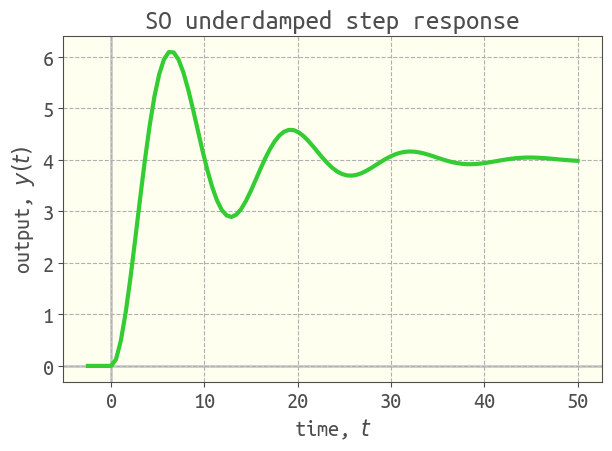

In [7]:
g = 4 / (4 * s ^ 2 + 0.8 * s + 1)
U = 1 / s
Y = g * U
data = simulate(Y, 50.0)

viz_response(data, plot_title="SO underdamped step response")
tight_layout()
savefig("../docs/src/SO_underdamped_step_response.png", format="png")

## inverting an input

$\mathcal{L}[t \cos(at)]= \dfrac{s^2-a^2}{(s^2+a^2)^2}$

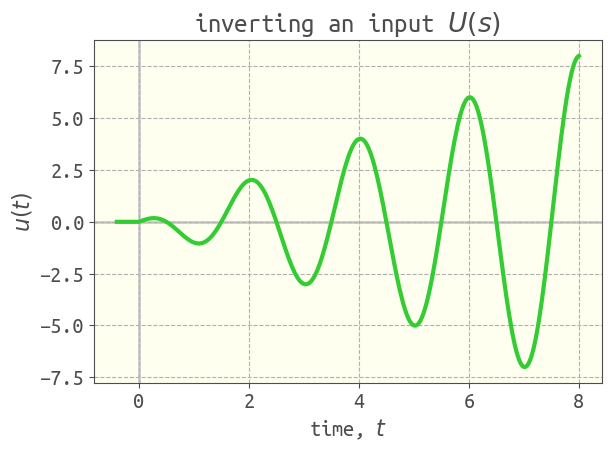

In [8]:
a = π
U = (s^2 - a^2) / (s^2 + a^2) ^ 2
data = simulate(U, 8.0, nb_time_points=300)

viz_response(data, plot_title=L"inverting an input $U(s)$", plot_ylabel=L"$u(t)$")
tight_layout()
savefig("../docs/src/tcosat.png", format="png")

## servo response of a control system

![](simple_servo.png)

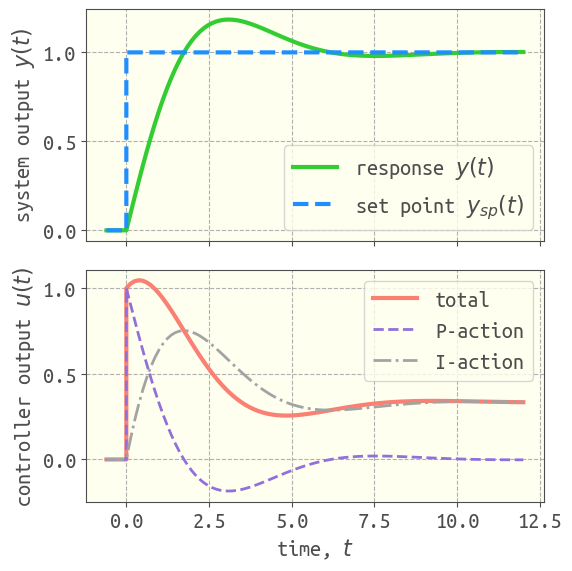

gc = 
1.0*s + 1.0
-----------
   1.0*s
gp = 
    3.0
-----------
4.0*s + 1.0
Y_sp = 
  1
-----
1.0*s


In [17]:
Kc = 1.0
τI = 1.0
pic = PIController(1.0, 1.0) 
gc = TransferFunction(pic) # controller transfer functio
@show gc

gp = 3 / (4 * s + 1) # process transfer function
@show gp

g_ol = gc * gp # open-loop transfer function

g_servo = g_ol / (1 + g_ol) # transfer function for servo response

Y_sp = 1 / s # unit step set point change
@show Y_sp

Y = g_servo * Y_sp # resulting output

E = Y_sp - Y # error signal

U = gc * E # resulting controller output

# break output into P-action, I-action
U_Paction = Kc * E
U_Iaction = Kc * τI / s * E

# simulate for y, u, ysp in the time domain
final_time = 12.0
y_data = simulate(Y, final_time)
u_data = simulate(U, final_time)
ysp_data = simulate(Y_sp, final_time)
u_Paction_data = simulate(U_Paction, final_time)
u_Iaction_data = simulate(U_Iaction, final_time)

fig, ax = subplots(2, 1, sharex=true, figsize=(6, 6))
xlabel(L"time, $t$")

ax[1].plot(y_data[:, :t], y_data[:, :output], label=L"response $y(t)$")
ax[1].plot(ysp_data[:, :t], ysp_data[:, :output], linestyle="--", label=L"set point $y_{sp}(t)$")
ax[1].legend()
ax[1].set_ylabel(L"system output $y(t)$")

ax[2].plot(u_data[:, :t], u_data[:, :output], color="C2", label="total")
ax[2].plot(u_Paction_data[:, :t], u_Paction_data[:, :output], color="C3", linestyle="--", label="P-action", lw=2)
ax[2].plot(u_Iaction_data[:, :t], u_Iaction_data[:, :output], color="C4", linestyle="-.", label="I-action", lw=2)
ax[2].legend()
ax[2].set_ylabel(L"controller output $u(t)$")
tight_layout()
savefig("../docs/src/simple_servo_response.png", format="png")

## a full feedback control system

![](full_feedback_control_system.png)

## viz poles and zeros of a transfer function

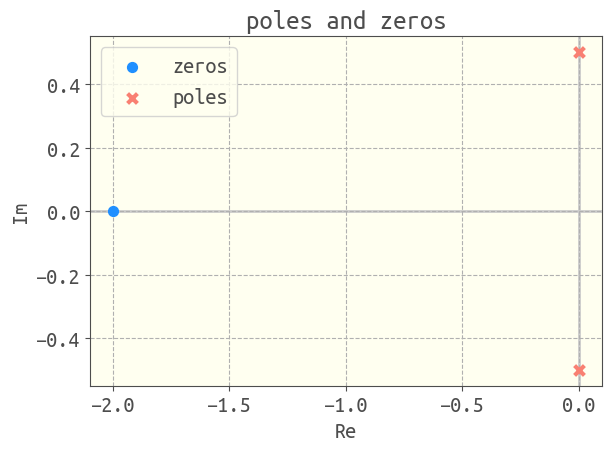

In [11]:
g = (s + 2) / (s^2 + 1/4)
viz_poles_and_zeros(g)
tight_layout()
savefig("../docs/src/example_poles_and_zeros.png", format="png")

## Nyquist diagram

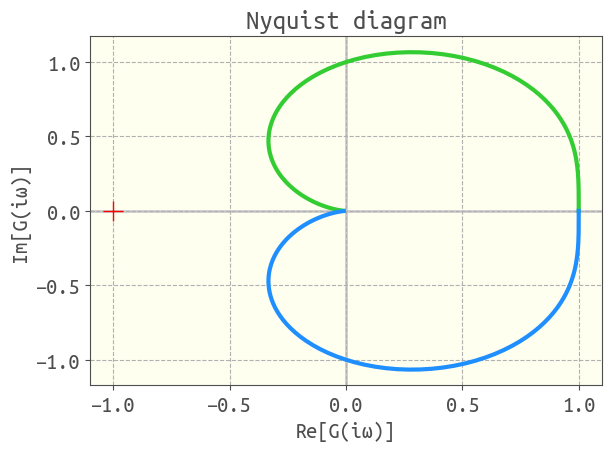

In [12]:
g = 1 / (s^2 + s + 1) # https://en.wikipedia.org/wiki/Nyquist_stability_criterion
nyquist_diagram(g)
tight_layout()
savefig("../docs/src/example_nyquist.png", format="png")

## root locus diagram

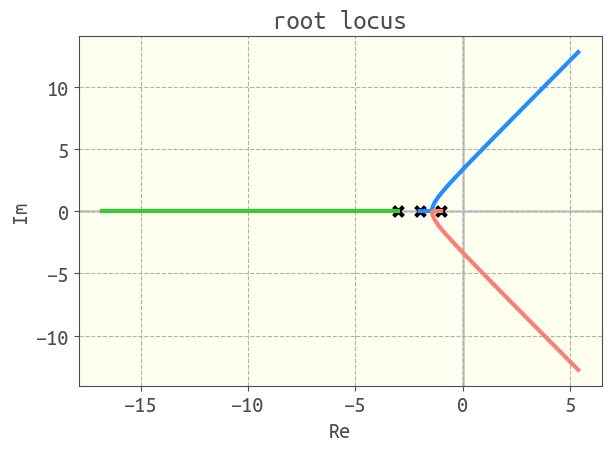

In [13]:
g_ol = 4 / (s + 3) / (s + 2) / (s + 1)

root_locus(g_ol)
tight_layout()
savefig("../docs/src/example_root_locus.png", format="png")

## Bode plot

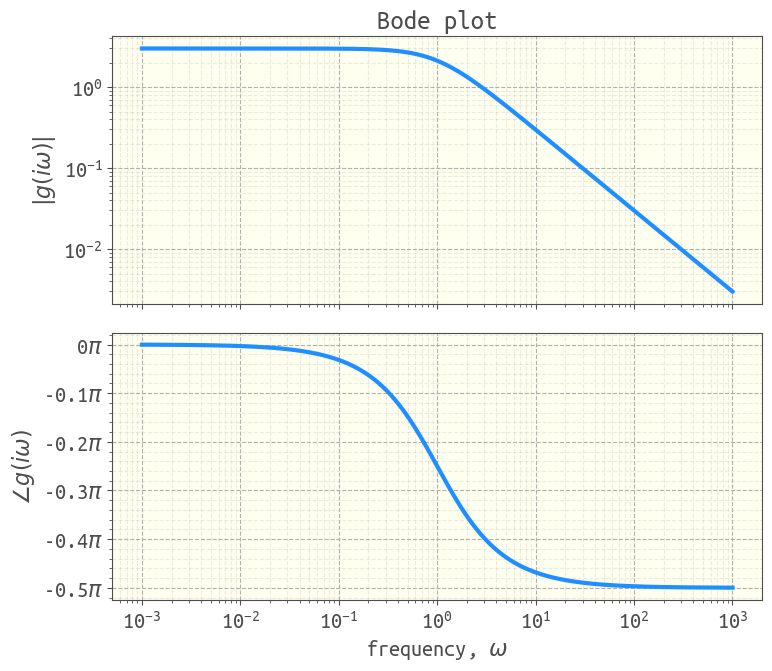

In [14]:
g = 3 / (s+1)

bode_plot(g)
tight_layout()
savefig("../docs/src/example_bode.png", format="png")

gain and phase margins, critical frequency, gain crossover frequency

In [15]:
margins = gain_phase_margins(g)

-- gain/phase margin info--
	critical frequency ω_c [rad/time]:       60578352361124176.00000
	gain crossover frequency ω_g [rad/time]: 2.82843
	gain margin:                             20192784120374724.00000
	phase margin:                            1.91063


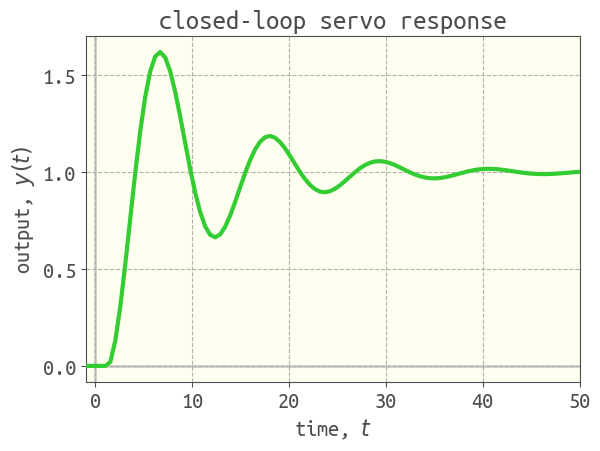

In [39]:
# PI controller transfer function
pic = PIController(1.0, 3.0)
gc = TransferFunction(pic)

# process, sensor dynamics
gu = 2 / (4 * s + 1) * exp(-0.5 * s)
gm = 1 / (s + 1) * exp(-0.75 * s)
gd = 6 / (6 * s + 1)

# open-loop transfer function
g_ol = gc * gu * gm

# closed-loop transfer function for regulator response
gr = ClosedLoopTransferFunction(gd, g_ol)

# closed-loop transfer function for servo response
gs = ClosedLoopTransferFunction(g_ol, g_ol)

# response to unit set point change
Y = gs / s
data = simulate(Y, 50.0)

# # response to unit step in disturbance d
# Y = gr / s
# data = simulate(Y, 45.0)

viz_response(data)
xlim([-1, 50])
title("closed-loop servo response")
tight_layout()
savefig("../docs/src/closed_loop_servo_time_delay.png", format="png")

In [16]:
# TODO rectangular pulse
M = 3.2
θ = 2.03
U = M / s * (1 - exp(-θ * s))
t, u = simulate(U, 12.0)
rec_pulse(t::Float64) = ((t < 0.0) || (t > θ)) ? 0.0 : M
@test isapprox(u, _rec_pulse.(t), rtol=0.001)

LoadError: we cannot add two transfer functions with two different time delays.

if you are trying to construct a closed-loop transfer function with a time delay,
instead use `ClosedLoopTransferFunction`.